# Aim 

1. Examine the output of the slurp model for SD1 in AD.  
2. Evalute if it is good enough to go production for kl estimation  


In [1]:
#load packages
import sqlite3
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [19]:
con = sqlite3.connect('./03processed-data/20200606PreProductionInspection.db')
mycur = con.cursor() 
mycur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
(mycur.fetchall())

[('Report',),
 ('SummaryNumbers',),
 ('_Checkpoints',),
 ('_Factors',),
 ('_InitialConditions',),
 ('_Messages',),
 ('_Simulations',),
 ('_Units',)]

In [3]:
Report = pd.read_sql('Select * from Report',  con)

In [4]:
Report

,CheckpointID,SimulationID,Experiment,FolderName,Crop,SKL,Zone,Date,InitialDepth,KLR,...,SW(7),SW(8),SW(9),SW(10),SW(11),SW(12),SW(13),RootDepth,Height,PSWC
0,1,1,LnP,Simulations,Lucerne,01,Field,2010-10-21 12:00:00,150.0,-0.002,...,0.112311,0.122045,0.141243,0.140481,0.135140,0.126000,0.126000,19.250000,400.000000,399.269752
1,1,1,LnP,Simulations,Lucerne,01,Field,2010-10-22 12:00:00,150.0,-0.002,...,0.110871,0.120930,0.140946,0.140922,0.140633,0.138032,0.126000,22.826923,1.412873,398.705104
2,1,1,LnP,Simulations,Lucerne,01,Field,2010-10-23 12:00:00,150.0,-0.002,...,0.110296,0.120327,0.140358,0.140387,0.140399,0.140281,0.128666,26.980769,2.384054,396.264607
3,1,1,LnP,Simulations,Lucerne,01,Field,2010-10-24 12:00:00,150.0,-0.002,...,0.110094,0.120106,0.140118,0.140132,0.140145,0.140152,0.130107,32.846154,3.448617,394.684438
4,1,1,LnP,Simulations,Lucerne,01,Field,2010-10-25 12:00:00,150.0,-0.002,...,0.110029,0.120033,0.140037,0.140042,0.140047,0.140052,0.130602,38.384615,4.858698,391.964810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,1,1,LnP,Simulations,Lucerne,01,Field,2012-07-27 12:00:00,150.0,-0.002,...,0.043013,0.037000,0.052000,0.050000,0.050000,0.140000,0.140000,2000.000000,129.710661,291.326522
743,1,1,LnP,Simulations,Lucerne,01,Field,2012-07-28 12:00:00,150.0,-0.002,...,0.043013,0.037000,0.052000,0.050000,0.050000,0.140000,0.140000,2000.000000,129.710661,290.413819
744,1,1,LnP,Simulations,Lucerne,01,Field,2012-07-29 12:00:00,150.0,-0.002,...,0.043013,0.037000,0.052000,0.050000,0.050000,0.140000,0.140000,2000.000000,129.710661,289.442597
745,1,1,LnP,Simulations,Lucerne,01,Field,2012-07-30 12:00:00,150.0,-0.002,...,0.043013,0.037000,0.052000,0.050000,0.050000,0.140000,0.140000,2000.000000,129.710661,299.642165


# First day is default model value - no good to keep 

In [5]:
Report.drop(0, inplace=True)
Report.set_index('Date', inplace=True)
Report.index = pd.to_datetime(Report.index)

In [6]:
Report.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 746 entries, 2010-10-22 12:00:00 to 2012-07-31 12:00:00
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CheckpointID  746 non-null    int64  
 1   SimulationID  746 non-null    int64  
 2   Experiment    746 non-null    object 
 3   FolderName    746 non-null    object 
 4   Crop          746 non-null    object 
 5   SKL           746 non-null    object 
 6   Zone          746 non-null    object 
 7   InitialDepth  746 non-null    float64
 8   KLR           746 non-null    float64
 9   RFV           746 non-null    float64
 10  k             746 non-null    float64
 11  cover         746 non-null    float64
 12  LAI           746 non-null    float64
 13  SW(1)         746 non-null    float64
 14  SW(2)         746 non-null    float64
 15  SW(3)         746 non-null    float64
 16  SW(4)         746 non-null    float64
 17  SW(5)         746 non-null    float6

In [7]:
keyparas = Report.loc[:, ['k', 'Height','LAI','cover']]
keyparas

,k,Height,LAI,cover
Date,,,,
2010-10-22 12:00:00,0.94,1.412873,0.003812,0.003045
2010-10-23 12:00:00,0.94,2.384054,0.006440,0.005139
2010-10-24 12:00:00,0.94,3.448617,0.009329,0.007435
2010-10-25 12:00:00,0.94,4.858698,0.013167,0.010478
2010-10-26 12:00:00,0.94,6.147381,0.016687,0.013261
...,...,...,...,...
2012-07-27 12:00:00,0.94,129.710661,0.423473,0.287360
2012-07-28 12:00:00,0.94,129.710661,0.423473,0.287360
2012-07-29 12:00:00,0.94,129.710661,0.423473,0.287360


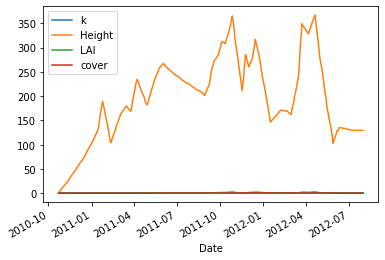

In [8]:
keyparas.plot()

k
Height
LAI
cover


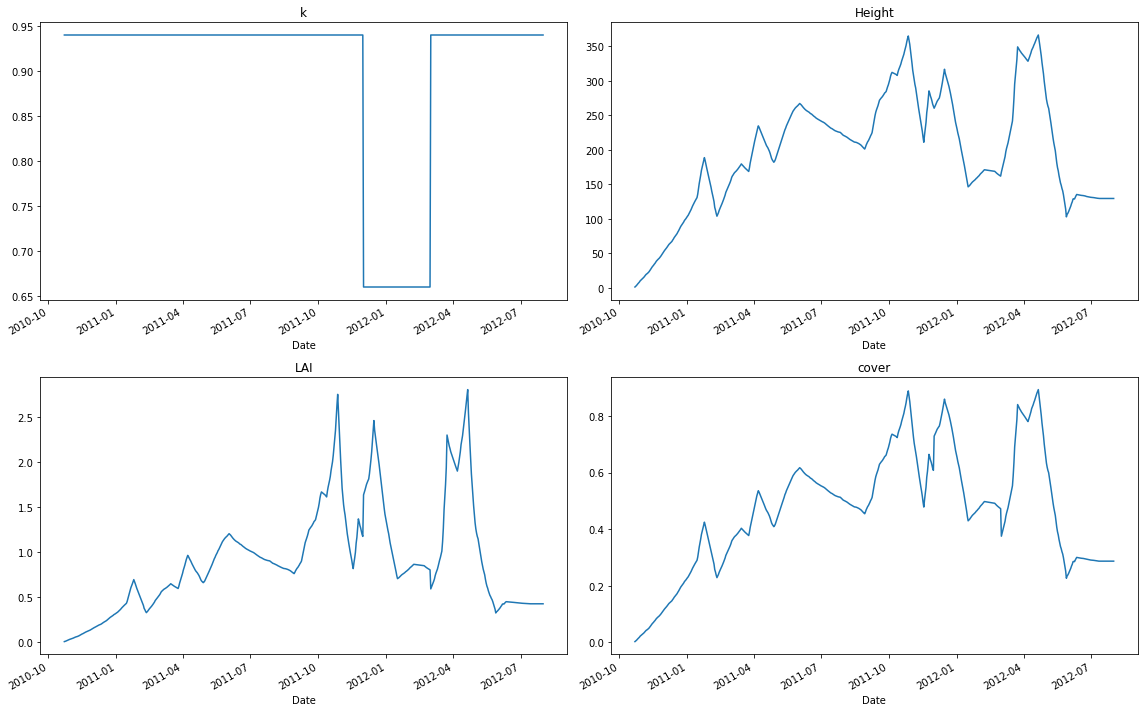

In [9]:
# Check if the replace take effect
plt.figure(figsize = (16,10))
pos = 1
for i in keyparas.columns:
    print(i)
    df = keyparas.loc[:, i]
    plt.subplot(2, 2, pos)
    plt.title(i)
    df.plot()
    plt.tight_layout()
    pos +=1


# Bring in the observed data

In [10]:
con = sqlite3.connect('./03processed-data/Richard.sqlite3')
mycur = con.cursor() 
mycur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
(mycur.fetchall())
biomass = pd.read_sql('Select * from biomass',  con)

In [11]:
LAI_Height = biomass.loc[(biomass['Seed'] == 'CS')
                         & (biomass['Harvest.No.']!='Post'), 
                         ['Experiment', 'Clock.Today', 'SowingDate', 'Rep',
                          'Plot', 'Rotation.No.', 'Harvest.No.', 'Height','LAImod']]
LAI_Height['k'] = 0.94
# Replace the k for the summur crop in Ashley Dene
LAI_Height.loc[(LAI_Height['Clock.Today'] > '2011-11-30') 
               & (LAI_Height['Clock.Today'] < '2012-03-01') 
               & (LAI_Height['Experiment'] == 'AshleyDene'), 'k'] = 0.66
LAI_Height['LI_frac'] = 1 - np.exp( - LAI_Height['k'] * LAI_Height['LAImod'])

In [12]:
LAI_Height.columns

Index(['Experiment', 'Clock.Today', 'SowingDate', 'Rep', 'Plot',
       'Rotation.No.', 'Harvest.No.', 'Height', 'LAImod', 'k', 'LI_frac'],
      dtype='object')

In [13]:
LAI_Height = LAI_Height.set_index(['Experiment', 'Clock.Today', 'SowingDate'])


In [14]:
idx=pd.IndexSlice
meanobs = LAI_Height.loc[idx['AshleyDene',:,'SD1'],[ 'Height', 'LAImod', 'k', 'LI_frac']].drop_duplicates().groupby('Clock.Today').mean()

In [15]:
meanobs.Height = meanobs.Height *10

In [16]:
meanobs.columns = ['Height','LAI','k', 'cover']

In [17]:
meanobs.index = pd.to_datetime(meanobs.index)

Height
LAI
k
cover


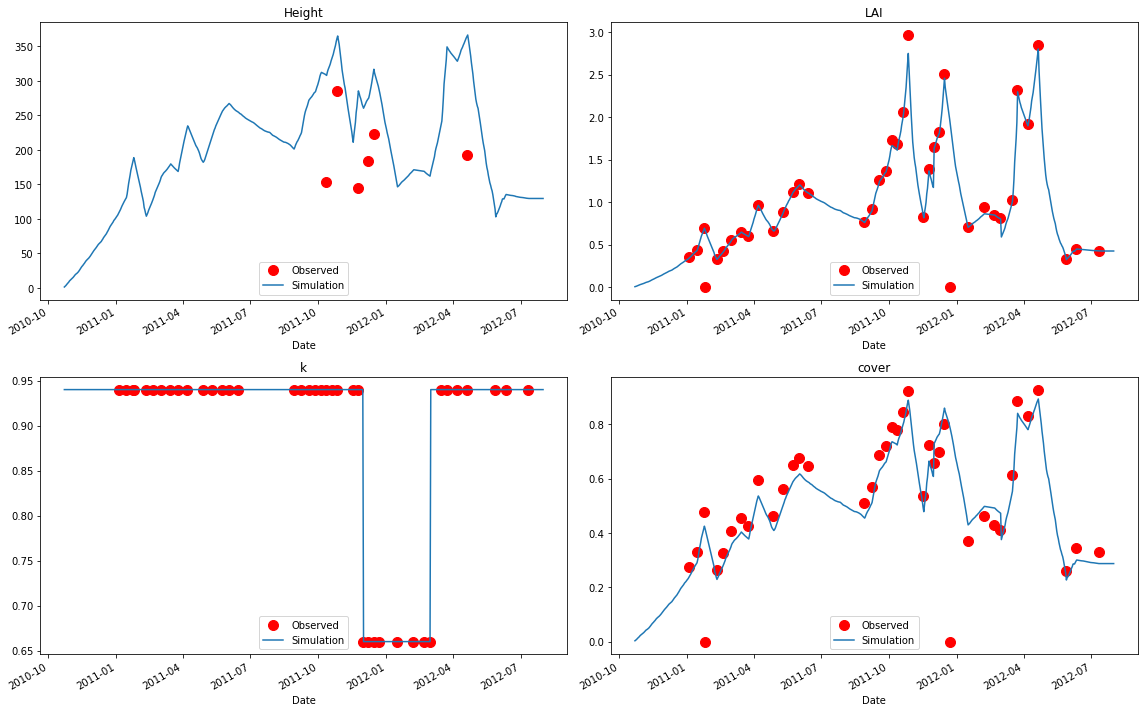

In [18]:
plt.figure(figsize = (16,10))
pos = 1
for i in meanobs.columns:
    print(i)
    df = meanobs.loc[:, i]
    df_sim = keyparas.loc[:, i]
    plt.subplot(2, 2, pos)
    plt.title(i)
    df.plot(marker = 'o', color = 'r',linestyle='None', ms = 10) 
    
    df_sim.plot()
    plt.legend(["Observed", "Simulation"], loc = 8)
    plt.tight_layout()
    
    pos +=1


### Notes

Height is not so great   **Wondering should I use TT to interpolate height as daily value as well**   

LAI almost bang on but with two 0s - possible be the 0 values in the post measruements. ignore is fine 
k as expected   
cover is similar like LAI
